In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import json
import os
import copy
import math
import random
import time

from collections import defaultdict

import numpy as np

## Data load

In [ ]:
save_path = '/content/gdrive/MyDrive/Colab Notebooks/Recognitaion_eye_written_char_with_siamese_net/v2_dataset/'

with open(save_path + 'eog_raw_numbers.json') as f:
  eog_raw_numbers = json.load(f)

with open(save_path + 'eog_eb_removed_numbers.json') as f:
  eog_eb_removed_numbers = json.load(f)

with open(save_path + 'eog_katakana.json') as f:
  eog_katakana = json.load(f)

with open(save_path + 'reference_data.json') as f:
  reference_data = json.load(f)


In [ ]:
# eog numbers without eye-blink removal

print(eog_raw_numbers.keys())
print(len(eog_raw_numbers['0']))
print(np.array(eog_raw_numbers['0'][0]).shape)
print(np.array(eog_raw_numbers['0'][1]).shape)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
54
(1112, 2)
(1161, 2)


In [ ]:
# eog numbers passed eye-blink removal

print(eog_eb_removed_numbers.keys())
print(len(eog_eb_removed_numbers['0']))
print(np.array(eog_eb_removed_numbers['0'][0]).shape)
print(np.array(eog_eb_removed_numbers['0'][1]).shape)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
54
(333, 2)
(343, 2)


In [ ]:
# eog katakana

print(eog_katakana.keys())
print(len(eog_katakana['1']))
print(np.array(eog_katakana['1'][0]).shape)
print(np.array(eog_katakana['1'][1]).shape)

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
60
(1250, 2)
(1250, 2)


In [ ]:
# reference data

print(reference_data.keys())
print(len(reference_data['katakana']))
print(len(reference_data['numbers']))

print(len(reference_data['katakana']['1'][0]))
print(np.array(reference_data['katakana']['1'][0]).shape)

print(len(reference_data['numbers']['0'][0]))
print(np.array(reference_data['numbers']['0'][0]).shape)


dict_keys(['katakana', 'numbers'])
12
10
720
(720, 2)
720
(720, 2)


## plot function

In [ ]:
# visualization

import matplotlib.pyplot as plt

def plot_images(data_dict):
  classes = list(data_dict.keys())
  n_cls = len(classes)
  n_data = len(data_dict[classes[0]])

  fig, axes = plt.subplots(n_data, n_cls, figsize=(5*n_cls, 5*n_data))

  for i, cls in enumerate(classes):

    if n_data == 1:
      x,y = zip(*data_dict[cls][0])

      axes[i].plot(x,y)
      axes[i].scatter(x,y)

      axes[i].set_xlim([-0.1,1.1])
      axes[i].set_ylim([-0.1,1.1])      

    else:
      for j, idx in enumerate(range(n_data)):
        x,y = zip(*data_dict[cls][idx])

        axes[j][i].plot(x,y)
        axes[j][i].scatter(x,y)

        axes[j][i].set_xlim([-0.1,1.1])
        axes[j][i].set_ylim([-0.1,1.1])      


## preprocessing

In [ ]:
# data normalization

def normalization(data_dict):
  '''
  중심점이 (0,0)이 되도록 데이터 내의 모든 값을 0~1 사이의 값으로 정규화한다.
  '''

  dataset = copy.deepcopy(data_dict)
  result = defaultdict(list)

  classes = dataset.keys()
  n_cls = len(classes)

  for cls in classes:
    n_data = len(dataset[cls])

    for idx in range(n_data):
      data = dataset[cls][idx]

      max_val = max(np.concatenate(data))
      min_val = min(np.concatenate(data))

      norm_points = []
      for point in data:
        x, y = point

        norm_x = round((x-min_val)/(max_val-min_val), 5)    # min max scaling
        norm_y = round((y-min_val)/(max_val-min_val), 5)

        norm_points.append([norm_x, norm_y])

      result[cls].append(norm_points)

  return result


In [ ]:
# 일반적으로 일정한 주기로 수집된 시계열 데이터들은 sampling 혹은 filtering 과정을 거친다.
# eye written character 는 불필요한 데이터의 집합 자체를 제거해야하기 때문에 filtering과는 다른 방식의 접근이 필요하다.

def noise_removal(data_dict, patch_size, ratio):
  '''
  필요 이상 모여있는 좌표 집합 (closed points set)을 제거한다.
  '''

  def bbox_diag_len(patch):
    # patch에 대한 bounding box의 대각선 길이
    x = np.array(patch)[:,0]
    y = np.array(patch)[:,1]
    min_x = np.min(x)
    max_x = np.max(x)
    min_y = np.min(y)
    max_y = np.max(y)
    dist =  math.sqrt((max_x-min_x)**2 + (max_y-min_y)**2)
    return round(dist, 4)

  dataset = copy.deepcopy(data_dict)
  result = defaultdict(list)

  classes = dataset.keys()
  n_cls = len(classes)

  for cls in classes:
    n_data = len(dataset[cls])

    for idx in range(n_data):
      data = dataset[cls][idx]

      # len_list = [len(data)]
      treadhold = 0.0
      i = 0
      while True:
        i += 1
        patch_list = []
        patch_diag_list = []

        cutting = len(data)%patch_size
        for p_idx in range(0, len(data)-cutting, patch_size):     # n개의 points로 이루어진 patch로 분리 (남는 부분 절삭)
          patch = data[p_idx:p_idx+patch_size]
          patch_list.append(patch)
          patch_diag_list.append(bbox_diag_len(patch))         # patch의 대각선 길이 저장
        
        if i == 1:
          diag_avg = np.mean(patch_diag_list)                 # 첫번째 iteration에서 대각선 길이의 중앙값을 기준으로 points의 상태를 구분한다.
          treadhold = float(diag_avg*ratio)

        new_patch_list = []
        for info in zip(patch_list, patch_diag_list):
          patch = np.array(info[0])
          diag = float(info[1])
          if diag < treadhold:
            x = round(np.mean(patch[:,0]), 4)
            y = round(np.mean(patch[:,1]), 4)
            new_patch_list.append([x,y])                  # points가 모여 있다고 판단되면 points의 중앙 값으로 치환
          else:
            new_patch_list.extend(patch.tolist())
        
        if data != new_patch_list:                        # 더이상 변화가 없다면 중지
          data = new_patch_list
        else:
          break

      #   len_list.append(len(data))
      # print(cls, idx, len_list)

      result[cls].append(data)

  return result


In [ ]:
# 일반적인 시계열 데이터는 시간에 대한 특징이 중요하게 작용한다.
# 하지만, eye written character의 경우 시계열 데이터지만, 2차원 공간에 대한 특성이 중요하기 때문에
# 점과 점 사이의 거리가 일정하도록 유지해야한다.
# 해당 데이터는 좌표의 정보보단 점과 점 사이의 이동 방향과 line이 중요하다.
# v1일 때는 좌표간 거리를 기준으로 계산 했지만, v2에는 point의 수를 기준으로 계산을 수행한다. 

def fill_points(data_dict, n_goal_points):
  '''
  전체 데이터 셋에
  데이터의 크기를 입력 데이터의 크기(input shape)로 변환한다.
  데이터의 크기가 목표 보다 클 경우, 그 차이 만큼 무작위 삭제를 한 후, (목표 수*n)개의 points를 추가하고, 추출한다.
  데이터의 크기가 목표 보다 작을 경우, (목표 수*n - 데이터의 수) 만큼 점과 점 사이 points를 추가한 후, 추출한다.
  points를 추가 할 땐, 한 데이터 내의 점과 점 사이 거리 list 중, 거리의 평균 이상인 지점 간 사이에 point를 추가하고 point가 소모 될 때 까지 이를 반복한다.
  '''

  def get_lines(data):
    lines = []
    distances = []
    for i in range(len(data)-1):     # 점과 점에 대한 연결과 거리를 저장
      line = data[i:i+2]
      dist = (abs(line[0][0]-line[1][0])**2+abs(line[0][1]-line[1][1])**2)**(1/2)
      lines.append(line)
      distances.append(dist)
    return lines, distances

  dataset = copy.deepcopy(data_dict)
  result = defaultdict(list)

  classes = dataset.keys()
  n_cls = len(classes)

  n = 2

  for cls in classes:
    n_data = len(dataset[cls])
    for idx in range(n_data):
      data = dataset[cls][idx]

      if len(data)>n_goal_points:
        data = random.sample(data, n_goal_points)     # 랜덤 제거
        n_add_points = n*n_goal_points                  # 추가할 좌표 수
      else:
        n_add_points = n*n_goal_points - len(data)

      cnt = 0
      while n_add_points!=0:                            # 추가해야 할 좌표를 감소 시키면서 반복
        
        lines, distances = get_lines(data)
        dist_avg = np.mean(distances)

        cnt +=1
        if cnt//2 == 0:                                 # 앞 뒤로 순서를 바꿔주며 points를 추가한다.
          lines.reverse()
          distances.reverse()
        
        new_lines = []
        for i, info in enumerate(zip(lines, distances)):
          line = info[0]
          dist = info[1]
          if dist > dist_avg and n_add_points!=0:                 # 거리가 평균보다 클 시 중점을 점과 점 사이에 추가
            line_arr = np.array(line)
            point = [round(sum(line_arr[:,0])/2, 4), 
                     round(sum(line_arr[:,1])/2, 4)]
            line.insert(1, point)
            n_add_points -= 1
          
          if i==0:                                        # 중복 좌표 제거
            new_lines.extend(line)
          else:
            new_lines.extend(line[1:])
        data = new_lines

      data = data[0::2]                                       # n개 중 홀수 요소만 추출해서 goal points 로 반감
      
      # print(cls, idx, len(data))
      result[cls].append(data)

  return result


In [ ]:
# 해당 데이터들은 수집 시작 시점과 끝나는 시점에 의미없는 points가 존재하기 때문에
# 끝단의 points를 조정하여 형태를 유지함과 동시에 좌표간 거리를 일정하게 한다.

def dist_equalizer(data_dict, dist_rate):
  '''
  하나의 데이터 내에 존재하는 점과 점사이 거리를 동일하게 조정한다.
  순서가 있는 두 점 사이의 거리가 데이터 내의 모든 distance의 평균과 비교하여 두번째 좌표(to_x, to_y의 위치를 조정한다. 
  '''

  def get_dist_avg(data):
    dist = 0.0
    n = 0
    for i in range(len(data)-1):
      line = data[i:i+2]
      dist += (abs(line[0][0]-line[1][0])**2+abs(line[0][1]-line[1][1])**2)**(1/2)
      n += 1
    return dist / n

  dataset = copy.deepcopy(data_dict)
  result = defaultdict(list)

  classes = dataset.keys()
  n_cls = len(classes)

  for cls in classes:
    n_data = len(dataset[cls])
    for idx in range(n_data):
      data = dataset[cls][idx]

      dist_avg = get_dist_avg(data)*dist_rate
      new_data = []
      for i in range(len(data)-1):
        line = data[i:i+2]
        from_x, from_y = line[0]
        to_x, to_y = line[1]
        dist = (abs(from_x - to_x)**2+abs(from_y - to_y)**2)**(1/2)
        
        if from_x < to_x:
          line[1][0] = round(from_x + abs(to_x-from_x)*dist_avg/dist, 4)
        elif from_x > to_x:
          line[1][0] = round(from_x - abs(to_x-from_x)*dist_avg/dist, 4)

        if from_y < to_y:
          line[1][1] = round(from_y + abs(to_y-from_y)*dist_avg/dist, 4)
        elif from_y > to_y:
          line[1][1] = round(from_y - abs(to_y-from_y)*dist_avg/dist, 4)

        if i==0:
          new_data.extend(line)
        else:
          new_data.append(line[-1])

      result[cls].append(new_data)

  return result


In [ ]:
input_size = 200

katakana_config = {
    'patch_size':5,
    'ratio':4.0,
    'n_goal_points':input_size,
    'dist_rate':1.0
}

raw_num_config = {
    'patch_size':5,
    'ratio':1.5,
    'n_goal_points':input_size,
    'dist_rate':1.0
}

eb_num_config = {
    'patch_size':5,
    'ratio':1.5,
    'n_goal_points':input_size,
    'dist_rate':1.0
}


In [ ]:
# katakana

start = time.time()

norm_katakana = normalization(eog_katakana)
noise_remove_katakana = noise_removal(norm_katakana, katakana_config['patch_size'], katakana_config['ratio'])
filled_katakana = fill_points(noise_remove_katakana, katakana_config['n_goal_points'])
equal_dist_katakana = dist_equalizer(filled_katakana, katakana_config['dist_rate'])

print('runtime :', time.time()-start)


runtime : 48.829314947128296


In [ ]:
# arabic numbers without eye-blink remove

start = time.time()

norm_raw_numbers = normalization(eog_raw_numbers)
noise_remove_raw_numbers = noise_removal(norm_raw_numbers, raw_num_config['patch_size'], raw_num_config['ratio'])
filled_raw_numbers = fill_points(noise_remove_raw_numbers, raw_num_config['n_goal_points'])
equal_dist_raw_numbers = dist_equalizer(filled_raw_numbers, raw_num_config['dist_rate'])

print('runtime :', time.time()-start)

runtime : 18.229773998260498


In [ ]:
# arabic numbers with eye-blink remove

start = time.time()

norm_eb_removed_numbers = normalization(eog_eb_removed_numbers)
noise_remove_eb_removed_numbers = noise_removal(norm_eb_removed_numbers, eb_num_config['patch_size'], eb_num_config['ratio'])
filled_eb_removed_numbers = fill_points(noise_remove_eb_removed_numbers, eb_num_config['n_goal_points'])
equal_dist_eb_removed_numbers = dist_equalizer(filled_eb_removed_numbers, raw_num_config['dist_rate'])

print('runtime :', time.time()-start)

runtime : 15.751246929168701


## reference data

In [ ]:
# 참고 데이터는 정규화 된 720개의 좌표들로 이루어져 있다.
# 720은 모든 수에 약분이 가능하다.

def sampler(data_dict, input_size):
  '''
  keypoints에 해당하는 좌표를 제외한 좌표들을 목표 수 (input_size)와 동일하게 한다.
  '''

  dataset = copy.deepcopy(data_dict)
  result = defaultdict(list)

  classes = dataset.keys()
  n_cls = len(classes)

  for cls in classes:
    n_data = len(dataset[cls])

    for idx in range(n_data):
      data = dataset[cls][idx]

      ratio = len(data)/input_size
      patch_size = int(ratio*10)
      new_data = []
      for i in range(0, len(data), patch_size):     # 크기가 ratio인 패치들로 분리 후 무작위로 10개 좌표
        patch = data[i:i+patch_size]
        indices = sorted(np.random.randint(0, len(patch), 10))
        samples = [patch[i] for i in indices]
        new_data.extend(samples)

      result[cls].append(new_data)
  
  return result


In [ ]:
ref_config = {'input_size':200,
              'dist_rate':1.5}

katakana_ref = reference_data['katakana']
numbers_ref = reference_data['numbers']

In [ ]:
# katakana ref

norm_katakana_ref = normalization(katakana_ref)
scaled_katakana_ref = sampler(norm_katakana_ref, ref_config['input_size'])
equal_katakana_ref = dist_equalizer(scaled_katakana_ref, ref_config['dist_rate'])

In [ ]:
# arabic numbers

norm_katakana_ref = normalization(numbers_ref)
scaled_numbers_ref = sampler(numbers_ref, ref_config['input_size'])
equal_numbers_ref = dist_equalizer(scaled_numbers_ref, ref_config['dist_rate'])

## plot

In [ ]:
# katakana eog data visualization

plot_images(equal_dist_katakana)

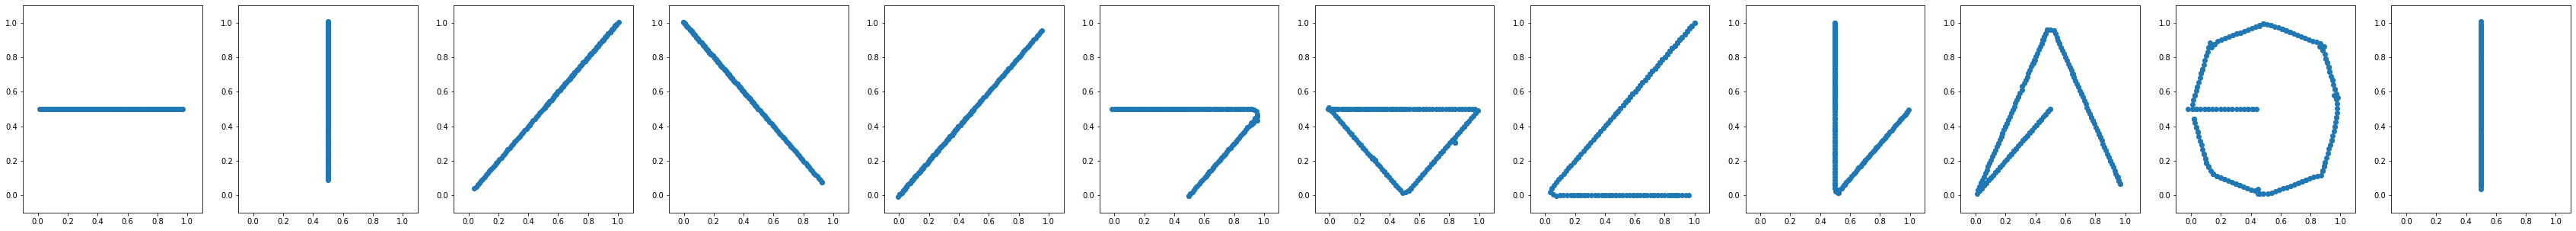

In [ ]:
# katakana reference data visualization

plot_images(equal_katakana_ref)

## save data

In [ ]:
save_path = '/content/gdrive/MyDrive/Colab Notebooks/Recognitaion_eye_written_char_with_siamese_net/v2_dataset/200_points_dataset/'

with open(save_path + 'eog_katakana_200.json','w') as f:
    json.dump(equal_dist_katakana,f)

with open(save_path + 'eog_raw_numbers_200.json','w') as f:
    json.dump(equal_dist_raw_numbers,f)

with open(save_path + 'eog_eb_remove_numbers_200.json','w') as f:
    json.dump(equal_dist_eb_removed_numbers,f)

reference_data = {'katakana': equal_katakana_ref,
                  'numbers' : equal_numbers_ref}

with open(save_path + 'reference_data_200.json','w') as f:
    json.dump(reference_data,f)
